<a id="1"></a>
# <div style="padding: 20px; color: cyan; margin: 0; font-size: 40px; font-family: Arial; text-align: left; border-radius: 5px; background-color: #000000; border: 2px solid blue;"><b>Preprocessing</b></div>

<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 30px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #008B8B; padding: 15px; border-top: 2px solid blue; border-bottom: 2px solid blue;
"><b>Import</b>

In [293]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_module import make_dataset
print("Setup Complete!")

Setup Complete!


<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 30px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #008B8B; padding: 15px; border-top: 2px solid blue; border-bottom: 2px solid blue;
"><b>Exploring</b> data

> <span style='font-size:25px; font-family:Arial; color: #87CEFA;'><b>
Read raw data </b></span>

In [294]:
# read data crawled
raw_df = pd.read_csv(f"../data/raw/raw_data.csv")

> <span style='font-size:25px; font-family:Arial; color: #87CEFA;'><b>
Number of rows and columns in the crawled data </b></span>

In [295]:
# Data columns
print(f"Data shape: {raw_df.shape}")
print(f"Rows = {raw_df.shape[0]}; Columns = {raw_df.shape[1]}")

Data shape: (5952, 20)
Rows = 5952; Columns = 20


> <span style='font-size:25px; font-family:Arial; color: #87CEFA;'><b>
Meaning of each column </b></span>

In [296]:
# Data columns
raw_df.head(2)

,name,description,designer,artist,publisher,min_players,max_players,min_playtime,max_playtime,playing_time,min_age,complexity_rating,user_ratings,user_comments,type,category,mechanism,family,year,average_rating
0,Samurai,Dispute the favor of three different castes in...,Reiner Knizia,Franz Vohwinkel,"Fantasy Flight Games, Hans im Glück + 15 more",2.0,4.0,30.0,60.0,45.0,10.0,2.47,16000,4000,Strategy,"Abstract Strategy, Medieval","Area Majority / Influence, Hand Management, He...",Components: Map (Continental / National scale)...,1998.0,7.5
1,Die Macher,Players represent political parties attempting...,Karl-Heinz Schmiel,"Bernd Brunnhofer, Marcus Gschwendtner, Harald ...","Hans im Glück, Moskito Spiele + 7 more",3.0,5.0,240.0,240.0,240.0,14.0,4.31,5700,2100,Strategy,"Economic, Negotiation, Political","Alliances, Area Majority / Influence, Auction/...","Country: Germany, Digital Implementations: VAS...",1986.0,7.6


| Column's Name      | Description                                               |
|--------------------|-----------------------------------------------------------|
| name               | Name of the game                                          |
| description        | A paragraph of text describing the game                   |
| designer           | Game designer                                             |
| artist             | Artist for game art                                       |
| publisher          | Company/person who published the game, separated by comma |
| min_players        | Minimum recommended players                               |
| max_players        | Maximum recommended players                               |
| min_playtime       | Minimum recommended playtime (min)                        |
| max_playtime       | Maximum recommended playtime (min)                        |
| playing_time       | Average playtime                                          |
| min_age            | Minimum recommended age                                   |
| complexity_rating  | The rating of complexity in game (on scale 1 to 5         |
| user_ratings       | Number of users that rated the game                       |
| user_comments      | Number of comments about the game                         |
| type               | Type of gameplay                                          |
| category           | Categories for the game (separated by commas)             |
| mechanism          | Game mechanic - how game is played, separated by comma    |
| family             | Family of game - equivalent to a publisher                |
| year               | Year game was published                                   |
| average_rating     | Average rating on Board Games Geek (1-10)                 |

> <span style='font-size:25px; font-family:Arial; color: #87CEFA;'><b>
De-duplicate for the raw data </b></span>

In [297]:
# De-duplicate your raw data
index = raw_df.index
detectDupSeries = index.duplicated(keep='first')
num_duplicated_rows = detectDupSeries.sum()

if num_duplicated_rows > 0:
    raw_df = raw_df.drop_duplicates(keep='first')
    print('Shape after de-deduplicate: ', raw_df.shape)
else:
    print('No duplicated row')

No duplicated row


> <span style='font-size:25px; font-family:Arial; color: #87CEFA;'><b>
Data type of each columns and comment about the suitability</b></span>

[//]: <> (Text)
<span style="font-size:20px; font-family:Arial;"> 

Data type I think should be changed:
- float64 -> int64: `min_players`, `max_players`, `min_playtime`, `max_playtime`, `playing_time`, `min_age`
- float64 -> nominal: `year`

</span>

In [298]:
# Raw data state
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               5632 non-null   object 
 1   description        5952 non-null   object 
 2   designer           5089 non-null   object 
 3   artist             3072 non-null   object 
 4   publisher          5948 non-null   object 
 5   min_players        5857 non-null   float64
 6   max_players        5857 non-null   float64
 7   min_playtime       4971 non-null   float64
 8   max_playtime       4971 non-null   float64
 9   playing_time       4971 non-null   float64
 10  min_age            5007 non-null   float64
 11  complexity_rating  3331 non-null   float64
 12  user_ratings       5952 non-null   int64  
 13  user_comments      5952 non-null   int64  
 14  type               5952 non-null   object 
 15  category           5881 non-null   object 
 16  mechanism          5194 

In [299]:
# Sumarize the missing ratio of each columns
def missing_ratio(s):
    return (s.isna().mean() * 100).round(1)

missing_df = raw_df.agg([missing_ratio])
missing_df.transpose()

,missing_ratio
name,5.4
description,0.0
designer,14.5
artist,48.4
publisher,0.1
min_players,1.6
max_players,1.6
min_playtime,16.5
max_playtime,16.5
playing_time,16.5


> <span style='font-size:25px; font-family:Arial; color: #87CEFA;'><b>
Distribution of numeric, text and categorial data</b></span>

In [300]:
# Check numeric data's status
numeric_info = raw_df.select_dtypes(exclude=['object', 'bool'])

def median(df):
    return (df.quantile(0.5)).round(1)

def lower_quartile(df):
    return (df.quantile(0.25)).round(1)

def upper_quartile(df):
    return (df.quantile(0.75)).round(1)

numeric_info = numeric_info.agg([missing_ratio, "min", lower_quartile, median, upper_quartile, "max"])
numeric_info

,min_players,max_players,min_playtime,max_playtime,playing_time,min_age,complexity_rating,user_ratings,user_comments,year,average_rating
missing_ratio,1.6,1.6,16.5,16.5,16.5,15.9,44.0,0.0,0.0,5.4,0.0
min,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,1000.0,1.0
lower_quartile,2.0,4.0,20.0,30.0,22.5,8.0,1.2,3.0,1.0,1999.0,5.6
median,2.0,4.0,30.0,45.0,40.0,10.0,2.0,10.0,5.0,2012.0,6.5
upper_quartile,2.0,6.0,60.0,90.0,75.0,12.0,2.6,59.0,26.0,2018.0,7.4
max,40.0,600.0,1500.0,12000.0,6060.0,30.0,5.0,123000.0,21000.0,2024.0,10.0


In [301]:
# Check nominal data's status
nominal_info = raw_df[['name', 'description', 'family']]
nominal_info = nominal_info.agg([missing_ratio])
nominal_info

,name,description,family
missing_ratio,5.4,0.0,24.3


In [302]:
# Check categorial data's status
category_info = raw_df[['designer', 'artist', 'publisher', 'type', 'category', 'mechanism']]

def num_values(s):
    s = s.astype(str).str.split(',')
    s = s.explode()
    return len(s.value_counts())

def value_ratios(s):
    s = s.astype(str).str.split(',')
    s = s.explode()
    totalCount = (~s.isna()).sum()
    return ((s.value_counts()/totalCount*100).round(1)).to_dict()

category_info = category_info.agg([missing_ratio, num_values, value_ratios])
category_info

,designer,artist,publisher,type,category,mechanism
missing_ratio,14.5,48.4,0.1,0.0,1.2,12.7
num_values,3745,3068,3378,15,175,321
value_ratios,"{'nan': 11.7, '(Uncredited)': 8.7, 'Reiner Kni...","{'nan': 38.3, '(Uncredited)': 2.3, 'Franz Vohw...","{'(Self-Published)': 3.9, '(Web published)': 3...","{'Uncategorized': 70.2, 'Wargames': 8.5, 'Abst...","{'Card Game': 7.2, 'Expansion for Base-game': ...","{'Dice Rolling': 6.4, 'nan': 5.0, ' Dice Rolli..."


<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 30px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #008B8B; padding: 15px; border-top: 2px solid blue; border-bottom: 2px solid blue;
"><b>Cleaning </b> data

[//]: <> (Text)
<span style="font-size:20px; font-family:Arial;"> 

After understanding data, we need to clean data by:
- `remove column with above half missing value`
- `fill in those missing values`
</span>

In [303]:
def drop_missing_features(df, missing_lst, threshold) -> pd.DataFrame:
    """Drop missing features from Pandas dataframe base on given threshold.

    Args:
        df (pd.DataFrame): Input dataframe for processing.
        missing_lst (dict, optional): Dict missing value rate which calculated from previous stage.
        threshold (float, optional): User threshold for dropping. (%)

    Returns:
        pd.DataFrame: Updated dataframe
    """
    if (df is None) or (missing_lst is None) or (threshold is None):
        print(f"[LOG] Invalid.")
        raise ValueError
    
    # Create a copy of the dataframe to avoid changing the original
    df_cp = df.copy()
    
    # List to maintain the columns to drop
    cols_to_trim = []
    
    for key, value in missing_lst.items():
        if float(value) > threshold:
            cols_to_trim.append(key)
            
    if len(cols_to_trim) > 0:
        # drop the columns identified using the dataframe drop() method
        df_cp = df_cp.drop(columns=cols_to_trim)
        print("[LOG] Dropped column(s): " + ", ".join(cols_to_trim))
    else:
        print("[LOG] Have no column(s) to trim.")
        
    return df_cp

In [304]:
# Drop columns with missing ratio > 50%
dropped_missing_df = drop_missing_features(raw_df, dict(missing_df.iloc[0]), 50.0)
dropped_missing_df.shape

[LOG] Have no column(s) to trim.


(5952, 20)

In [305]:
def filling_missing_value(df) -> pd.DataFrame:
    if (df is None):
        print(f"[LOG] Invalid.")
        raise ValueError
    
    # Create a copy of the dataframe to avoid changing the original
    df_cp = df.copy()
    
    # Get the list of columns in the dataframe
    cols_list = list(df_cp.columns)
    
    # Replace all None values with NaN, fillna only works on nans
    df_cp.fillna(value=np.nan, inplace=True)
    
    # Replace all NaN values with the mean of the column values
    for col in cols_list:
        # categorial data
        if df_cp[col].dtype in ['object', 'bool']:
            df_cp[col].fillna((df_cp[col].mode()[0]), inplace=True)

        # numeric data
        elif df_cp[col].dtype in ['int64', 'float64']:
            df_cp[col].fillna((df_cp[col].mean()), inplace=True)
        
    return df_cp
    

In [306]:
# Fill missing values in dataframe
filled_missing_df = filling_missing_value(dropped_missing_df)

new_missing_df = filled_missing_df.agg([missing_ratio])
new_missing_df

,name,description,designer,artist,publisher,min_players,max_players,min_playtime,max_playtime,playing_time,min_age,complexity_rating,user_ratings,user_comments,type,category,mechanism,family,year,average_rating
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> <span style='font-size:25px; font-family:Arial; color: #87CEFA;'><b>
Visualizing data to find outliers </b></span>

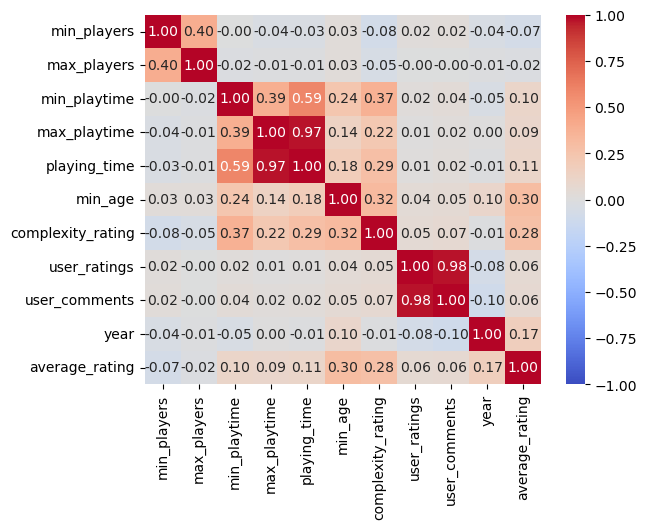

In [307]:
# correlation matrix
correlation_matrix = filled_missing_df.select_dtypes(exclude=['object', 'bool']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.show()

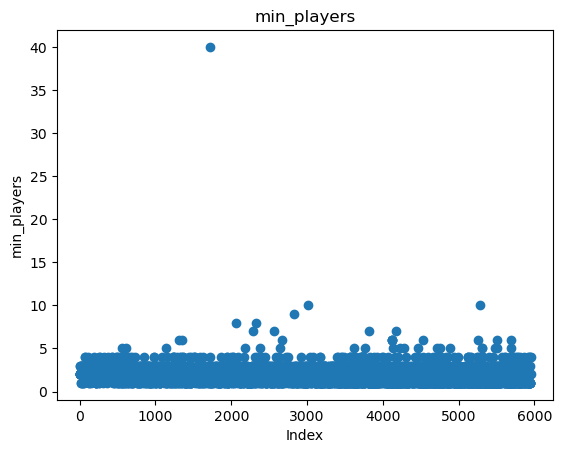

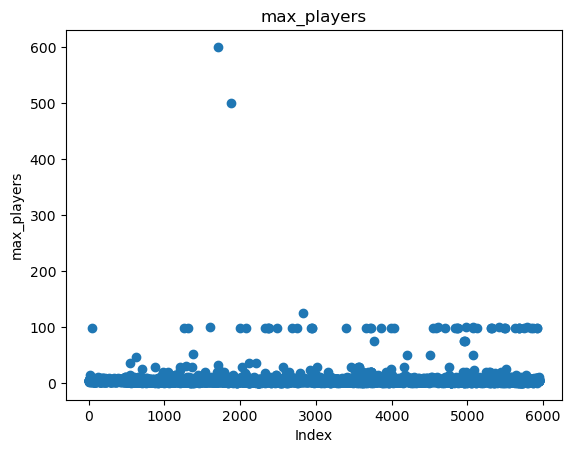

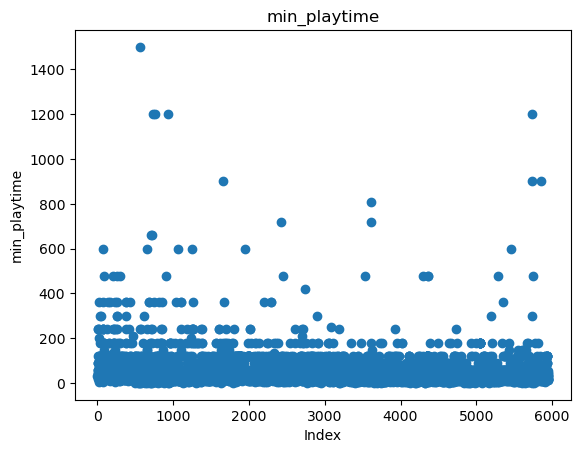

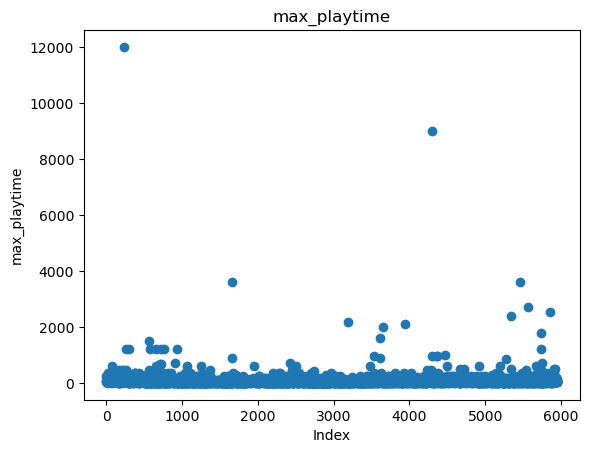

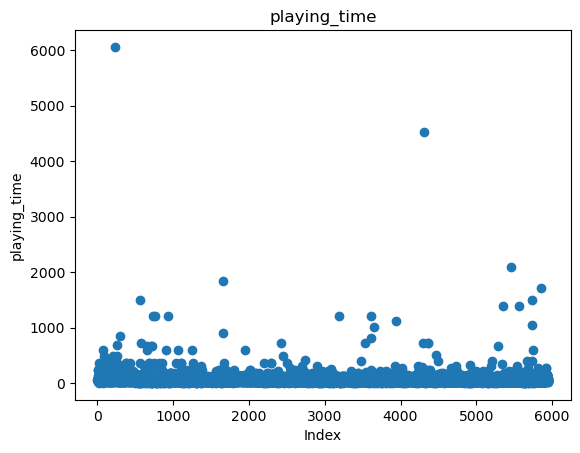

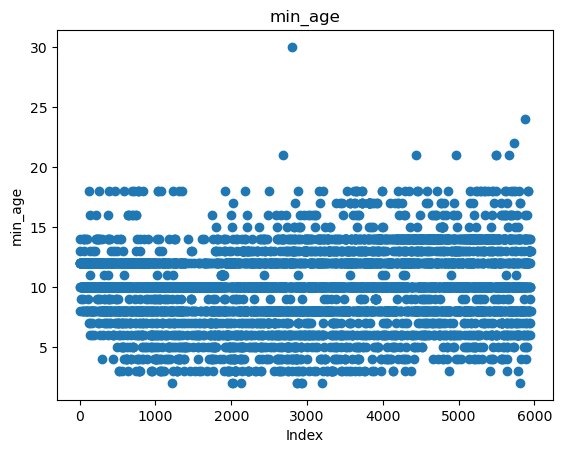

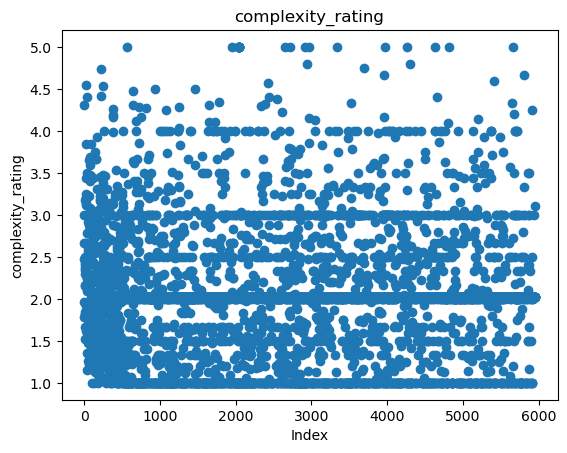

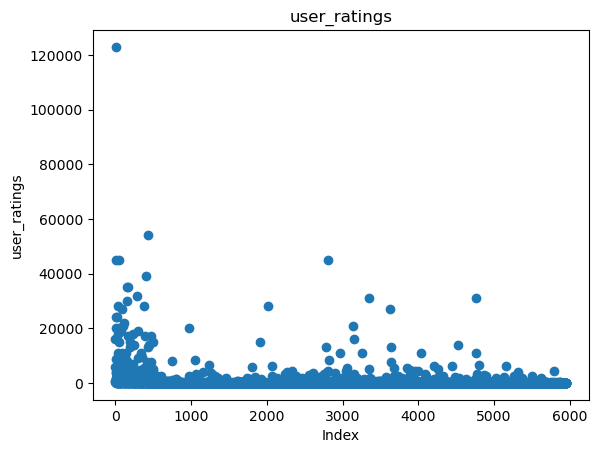

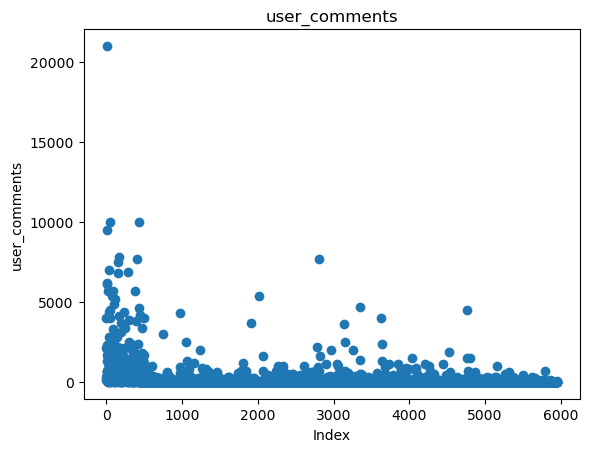

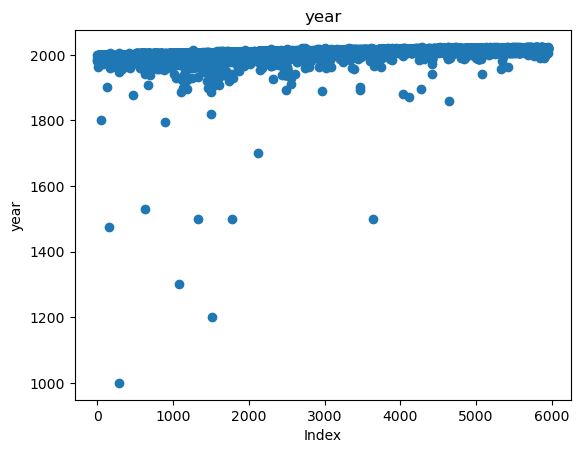

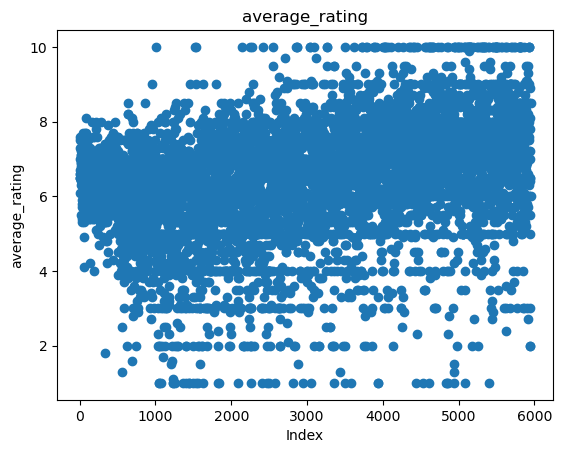

In [308]:
# Visualizing data
for col in filled_missing_df.select_dtypes(exclude=['object', 'bool']):
    temp_df = filled_missing_df[col]
    plt.scatter(temp_df.index, temp_df)
    plt.title(col)
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.show()

### Comment about outliers:

After cleaning, there are some columns that have outliers to be eliminated: 

<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 30px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #008B8B; padding: 15px; border-top: 2px solid blue; border-bottom: 2px solid blue;
"><b>Removing </b> Outliers

In [309]:
# 'min_players', 'max_players', 'min_playtime', 'max_playtime', 'playing_time'
# remove top 0.5% highest outliers & value = 0
column_names = ['min_players', 'max_players', 'min_playtime', 'max_playtime', 'playing_time']
remove_outliers_df = filled_missing_df.copy()

# Remove top 0.5% highest outliers
threshold_value = remove_outliers_df[column_names].quantile(0.995)
outlier_mask = (remove_outliers_df[column_names] <= threshold_value).all(axis=1)
remove_outliers_df = remove_outliers_df[outlier_mask]

# Remove rows where any value in 'min_players' or 'max_players' is 0
zero_mask = (remove_outliers_df[column_names] > 0).all(axis=1)
remove_outliers_df = remove_outliers_df[zero_mask]

# Update the index
remove_outliers_df.reset_index(drop=True, inplace=True)

remove_outliers_df.shape

(5888, 20)

In [310]:
# 'Year'

# remove year < 1900s
remove_outliers_df = remove_outliers_df[remove_outliers_df['year'] >= 1900]

# Reset the index after removing rows
remove_outliers_df.reset_index(drop=True, inplace=True)

remove_outliers_df.shape

(5864, 20)

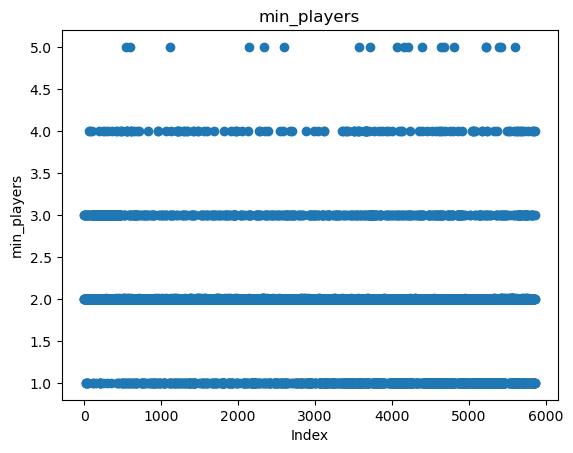

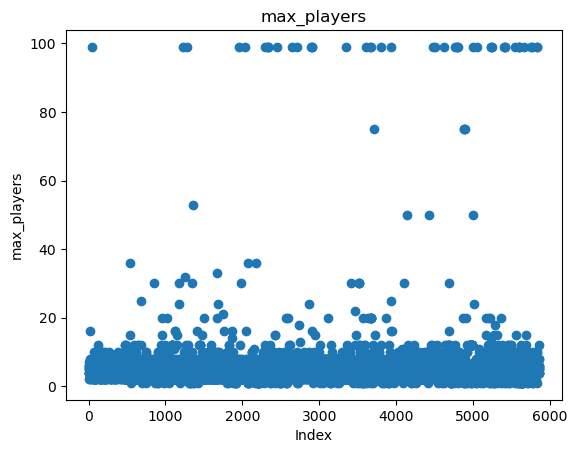

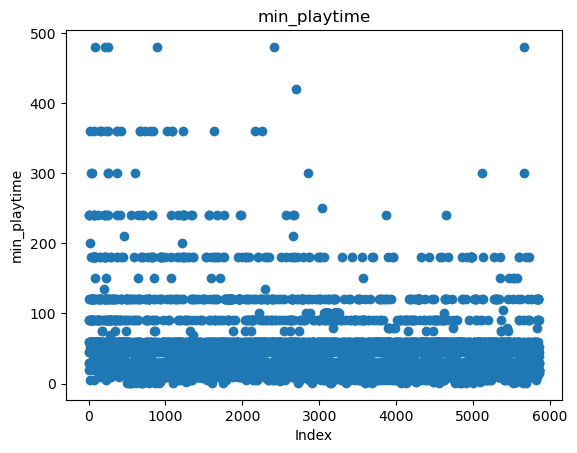

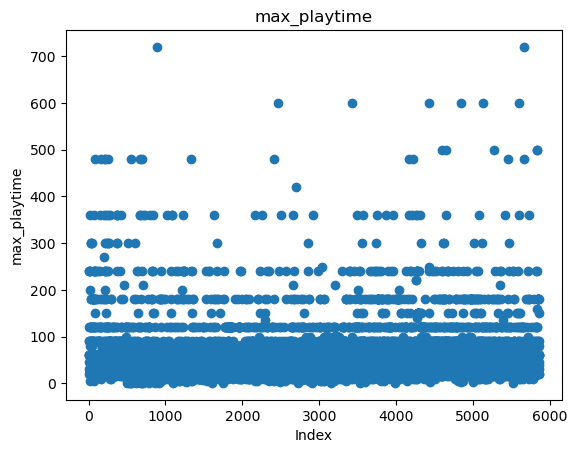

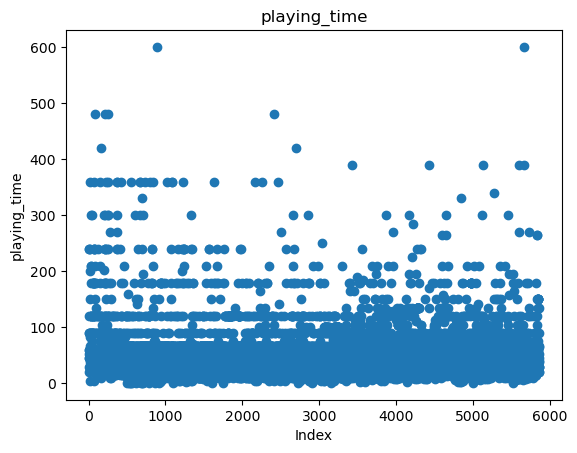

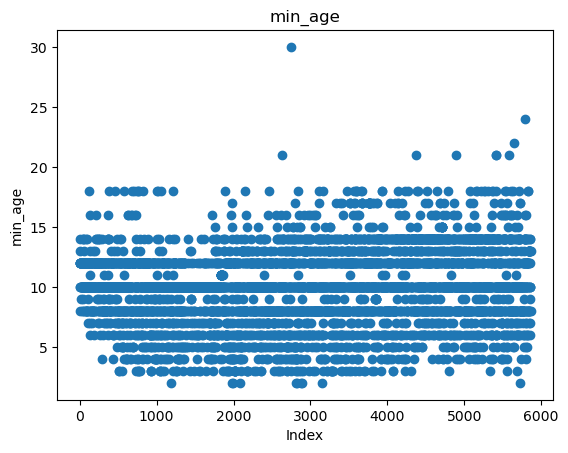

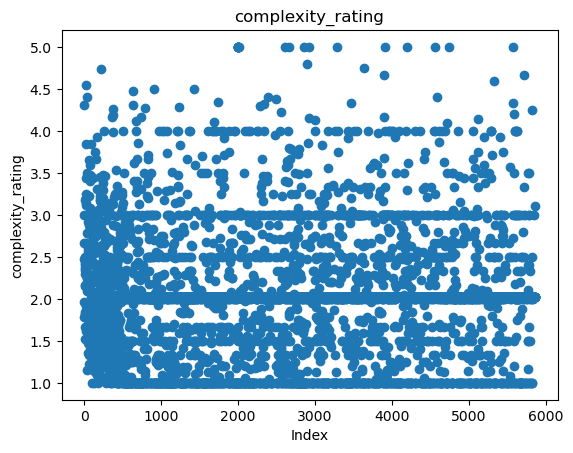

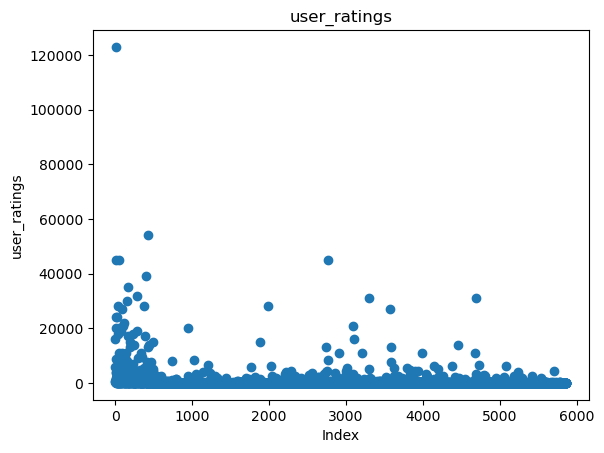

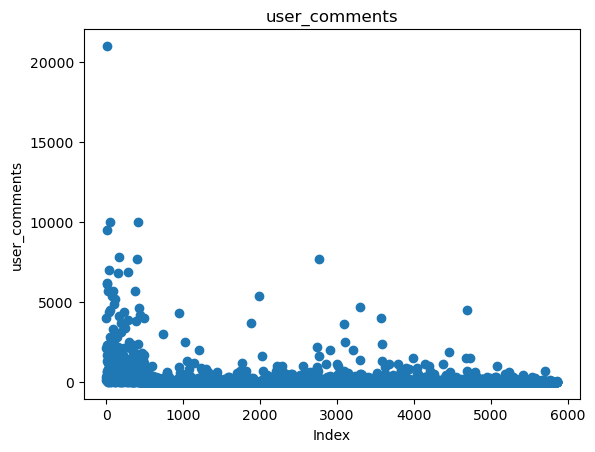

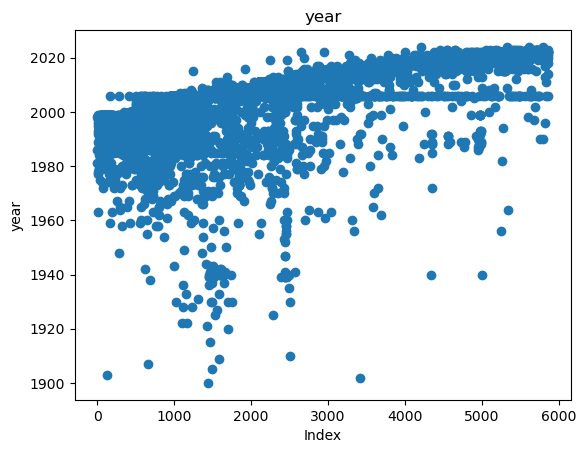

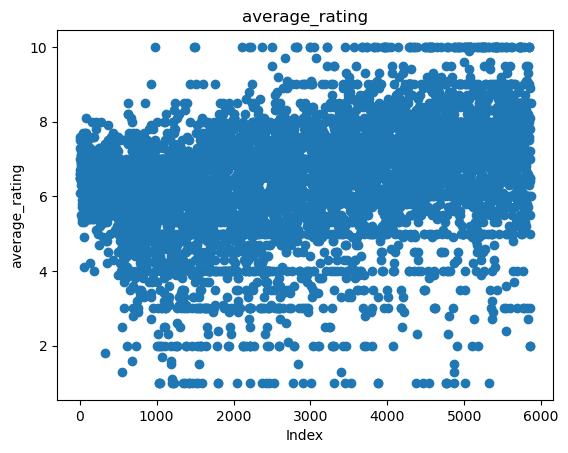

In [311]:
# Visualizing data
for col in remove_outliers_df.select_dtypes(exclude=['object', 'bool']):
    temp_df = remove_outliers_df[col]
    plt.scatter(temp_df.index, temp_df)
    plt.title(col)
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.show()

<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 30px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #008B8B; padding: 15px; border-top: 2px solid blue; border-bottom: 2px solid blue;
"><b>Transformating </b> data

[//]: <> (Text)
<span style="font-size:20px; font-family:Arial;"> 

Some column's data type is not suitable, we need to change that
</span>

In [312]:
# Cast suitable data type for some columns
casted_type_df = remove_outliers_df.copy()

# float64 -> str
casted_type_df['year'] = casted_type_df['year'].astype(str)

# float64 -> int64
temp_name_list = ['min_players', 'max_players', 'min_playtime', 'max_playtime', 'playing_time', 'min_age']
casted_type_df[temp_name_list] = casted_type_df[temp_name_list].astype(np.int64)

# recheck
casted_type_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5864 entries, 0 to 5863
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               5864 non-null   object 
 1   description        5864 non-null   object 
 2   designer           5864 non-null   object 
 3   artist             5864 non-null   object 
 4   publisher          5864 non-null   object 
 5   min_players        5864 non-null   int64  
 6   max_players        5864 non-null   int64  
 7   min_playtime       5864 non-null   int64  
 8   max_playtime       5864 non-null   int64  
 9   playing_time       5864 non-null   int64  
 10  min_age            5864 non-null   int64  
 11  complexity_rating  5864 non-null   float64
 12  user_ratings       5864 non-null   int64  
 13  user_comments      5864 non-null   int64  
 14  type               5864 non-null   object 
 15  category           5864 non-null   object 
 16  mechanism          5864 

In [313]:
# drop some un-used columns: 'description', 'publisher', 'family'
re_construct_df = casted_type_df.copy()
re_construct_df = re_construct_df.drop(columns=['description', 'publisher', 'family'])
re_construct_df.shape

(5864, 17)

In [314]:
# re-construct some columns: 'category', 'mechanism'
re_construct_df['category'] = re_construct_df['category'].apply(lambda x: [category.strip() for category in x.split(',')])
re_construct_df['mechanism'] = re_construct_df['mechanism'].apply(lambda x: [mechanism.strip() for mechanism in x.split(',')])

re_construct_df.head(1)[['category', 'mechanism']]

,category,mechanism
0,"[Abstract Strategy, Medieval]","[Area Majority / Influence, Hand Management, H..."


<a id="1.2"></a>
<h2 style=" font-family: Arial; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #008B8B; padding: 15px; border-top: 2px solid blue; border-bottom: 2px solid blue;
"><b>Saving </b> data

In [315]:
# final check
final_df = re_construct_df.copy()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5864 entries, 0 to 5863
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               5864 non-null   object 
 1   designer           5864 non-null   object 
 2   artist             5864 non-null   object 
 3   min_players        5864 non-null   int64  
 4   max_players        5864 non-null   int64  
 5   min_playtime       5864 non-null   int64  
 6   max_playtime       5864 non-null   int64  
 7   playing_time       5864 non-null   int64  
 8   min_age            5864 non-null   int64  
 9   complexity_rating  5864 non-null   float64
 10  user_ratings       5864 non-null   int64  
 11  user_comments      5864 non-null   int64  
 12  type               5864 non-null   object 
 13  category           5864 non-null   object 
 14  mechanism          5864 non-null   object 
 15  year               5864 non-null   object 
 16  average_rating     5864 

In [316]:
# Save preprocessed data into csv file
preprocessed_df = final_df.copy()
preprocessed_df.to_csv(f"../data/processed/processed_data.csv", index=False)